In [1]:
import pandas as pd
import numpy as np
import csv as csv
from datetime import *
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import random
from scipy.stats import mode
from collections import Counter  
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, StratifiedKFold, GroupKFold
import jieba, re
%matplotlib inline

plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
plt.rcParams['text.color'] = 'white'

In [3]:
# ÂØºÂÖ•Êï∞ÊçÆ
df = pd.read_table('../data/oppo_data_ronud2_20181107/data_train.txt', 
                   names= ['prefix','query_prediction','title','tag','label'], header=None, na_values='', keep_default_na=False, encoding='utf-8', quoting=3)
print(df.count())
print(df.head())
validDf = pd.read_table('../data/oppo_data_ronud2_20181107/data_vali.txt', 
                        names = ['prefix','query_prediction','title','tag','label'], header=None, na_values='', keep_default_na=False, encoding='utf-8', quoting=3)
predictDf = pd.read_table('../data/oppo_data_ronud2_20181107/data_testB.txt', 
                        names = ['prefix','query_prediction','title','tag','label'], header=None, na_values='', keep_default_na=False, encoding='utf-8', quoting=3)
print(validDf.info())
print(predictDf.info())

prefix              2000000
query_prediction    1946144
title               2000000
tag                 2000000
label               2000000
dtype: int64
  prefix                                   query_prediction  \
0      ÁæÅ  {"ÁæÅ": "0.136", "ÁæÅÁªäÊÄé‰πàËØª": "0.027", "ÁæÅÁªä": "0.141"...   
1   ÂÖ≠Âêà                                                NaN   
2    Á∫¢Â≤©Èáë  {"Á∫¢Â≤©ÈáëÂàöÂêéÂÖ´ËΩÆ": "0.024", "Á∫¢Â≤©ÈáëÂàö‰∫åÊâãËΩ¶": "0.044", "Á∫¢Â≤©ÈáëÂàö...   
3   È´òÂæ∑Âú∞Âõæ  {"È´òÂæ∑Âú∞Âõæ": "0.576", "È´òÂæ∑Âú∞ÂõæÂÖçË¥πÂØºËà™": "0.117", "È´òÂæ∑Âú∞ÂõæÂÖçË¥π...   
4  12306  {"12306ÂÆòÁΩë": "0.081", "12306app": "0.007", "123...   

                title tag  label  
0                   ÁæÅ  ÁôæÁßë      1  
1          ÂÖ≠Èó¥ÊàøÁßÄÂú∫-ËßÜÈ¢ëÁõ¥Êí≠  Â∫îÁî®      0  
2  Á∫¢Â≤©ÈáëÂàö‰ª™Ë°®Áõò‰∏äÁöÑÁÅØÂêÑ‰ª£Ë°®‰ªÄ‰πàÊÑèÊÄùÔºü  Áü•ÈÅì      0  
3                È´òÂæ∑Âú∞Âõæ  Â∫îÁî®      1  
4         12306ÈìÅË∑ØËÆ¢Á•®ÂÆòÁΩë  ÁΩëÁ´ô      0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50

In [3]:
# ‰∏Ä‰∏™prefixÂØπÂ∫îÂ§öÂ∞ëÁßçquery
tempDf = pd.concat([df, validDf, predictDf], ignore_index=True)
tempDf = tempDf.groupby('prefix')['query_prediction'].agg('nunique')
print(tempDf.value_counts())

1    225599
0     15435
Name: query_prediction, dtype: int64


**Ë∑üÂàùËµõ‰∏ÄÊ†∑ÔºåÂêåÊ†∑ÁöÑprefixÂÆÉÁöÑÈ¢ÑÊµãËØçÂàóË°®‰πüÊòØ‰∏ÄÊ†∑ÁöÑ**

In [7]:
# Á†îÁ©∂tagÁöÑÂèñÂÄºÊÉÖÂÜµ
tempDf = df['tag'].value_counts().to_frame('train')
tempDf = tempDf.merge(validDf['tag'].value_counts().to_frame('vali'), 'outer', left_index=True, right_index=True)
tempDf = tempDf.merge(predictDf['tag'].value_counts().to_frame('testB'), 'outer', left_index=True, right_index=True)
print(tempDf)

      train   vali  testB
ÂÅ•Â∫∑   114563   2728  10651
ÂïÜÂìÅ     4953    104    442
Â∫îÁî®   381586  10268  40872
ÂΩ±ËßÜ    37763   1412   5752
Âø´Â∫îÁî®   15045    466   1809
ÊóÖÊ∏∏     2809     71    273
ÊôØÁÇπ    15259    290   1140
Ê≠åÊâã    13270    304   1151
Ê±ΩËΩ¶    25419    530   2109
Ê∏∏Êàè    24989    482   2373
ÁÅ´ËΩ¶     1107     24     84
ÁôæÁßë   683206  16550  68709
Áü•ÈÅì    88263   2122   8859
ÁªèÈ™å    91775   2214   8437
ÁΩëÁ´ô   122696   3444  12290
ÁΩëÈ°µ   172371   4150  16547
Ëà™Áè≠      591     20     47
ËèúË∞±    85382   2029   7669
ÈÖíÂ∫ó      355      9     35
ÈòÖËØª    59177   1364   5144
Èü≥‰πê    59421   1419   5607


In [3]:
def formatQuery(df):
    '''
    Ê†ºÂºèÂåñÈ¢ÑÊµãËØçÂ≠óÊÆµ
    '''
    tempDf = df[['prefix','query_prediction']].drop_duplicates(subset='prefix')
    def format(x):
        x = eval(x)
        x = {k:float(v) for k,v in x.items()}
        return x
    tempDf['query_prediction'] = tempDf['query_prediction'].dropna().map(lambda x: format(x))
    tempDf['query_predict_num'] = tempDf['query_prediction'].dropna().map(lambda x: len(x))
    tempDf.loc[tempDf.query_predict_num==0, 'query_prediction'] = np.nan
    tempDf['query_predict_num'].fillna(0, inplace=True)
    tempDf['query_word'] = tempDf['query_prediction'].dropna().map(lambda x: list(x.keys()))
    tempDf['query_ratio'] = tempDf['query_prediction'].dropna().map(lambda x: list(x.values()))
    df = df.drop(['query_prediction'], axis=1).merge(tempDf, how='left', on=['prefix'])
    return df

df = formatQuery(df)
validDf = formatQuery(validDf)
predictDf = formatQuery(predictDf)

df['flag'] = 0
df = df.reset_index().rename(columns={'index':'instance_id'})
validDf['flag'] = 1
validDf = validDf.reset_index().rename(columns={'index':'instance_id'})
predictDf['flag'] = -1
predictDf = predictDf.reset_index().rename(columns={'index':'instance_id'})

## Á†îÁ©∂Êó∂Â∫è‰ø°ÊÅØ

In [8]:
# Á†îÁ©∂prefixÊòØÂê¶ÊúâÊó∂Â∫è‰ø°ÊÅØ
# titleUnique = df.groupby('prefix')['title'].nunique()
tempDf = df.sort_values(['prefix','instance_id'])
tempDf['previous_id'] = tempDf['instance_id'].shift(1)
tempDf['delta_id'] = tempDf['instance_id'] - tempDf['previous_id']

tempDf['temp'] = (tempDf.delta_id>0)&(tempDf.delta_id<5)
tempDf['temp'] = (tempDf['temp'].shift(-1) | tempDf['temp'])
print(tempDf.iloc[100000:1000000][tempDf.temp][['prefix','title','label']])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


        prefix                   title  label
326621    puma                ÊàëÁöÑPUMAÊÉÖÁªì      0
326622    puma                    ÂΩ™È©¨ÂÆòÁΩë      1
326625    puma                    ÂΩ™È©¨ÂÆòÁΩë      1
326627    puma                ÊàëÁöÑPUMAÊÉÖÁªì      0
326629    puma                ÊàëÁöÑPUMAÊÉÖÁªì      0
326630    puma              Yoho!BuyÊúâË¥ß      0
326631    puma                    ÂΩ™È©¨ÂÆòÁΩë      0
326633    puma                    ÂΩ™È©¨ÂÆòÁΩë      1
326635    puma                    ÂΩ™È©¨ÂÆòÁΩë      1
326636    puma              Yoho!BuyÊúâË¥ß      0
326638    puma                    ÂΩ™È©¨ÂÆòÁΩë      1
326641    puma                ÊàëÁöÑPUMAÊÉÖÁªì      0
326643    puma                    ÂΩ™È©¨ÂÆòÁΩë      1
326646    puma                    ÂΩ™È©¨ÂÆòÁΩë      1
326647    puma                ÊàëÁöÑPUMAÊÉÖÁªì      0
326651    puma                ÊàëÁöÑPUMAÊÉÖÁªì      0
326652    puma                    ÂΩ™È©¨ÂÆòÁΩë      1
326655    puma              Yoho!BuyÊúâË¥ß  

/home/admin/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/admin/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/admin/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `ar

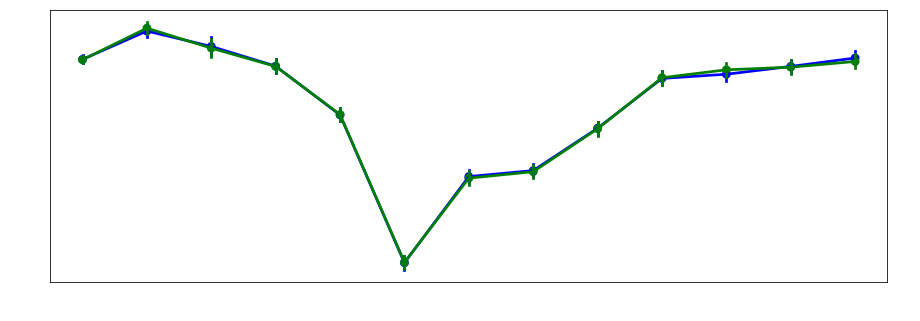

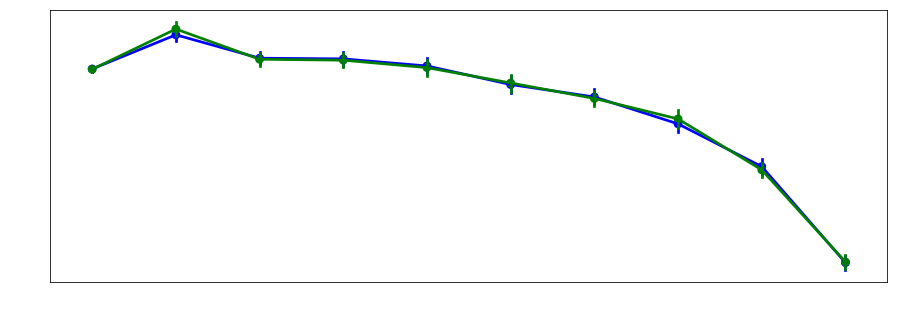

In [11]:
# ÁåúÊµãÔºöÁü≠ÊúüÂÜÖÈáçÂ§çÂá∫Áé∞ÁöÑtitleÔºåÊ†áÁ≠æÊòØÂê¶ÊúâËßÑÂæã
tempDf = df.sort_values(['title','instance_id'])
tempDf['temp'] = tempDf['title'].shift(1)
tempDf['pre_title'] = tempDf['instance_id'].shift(1)
tempDf['pre_title'] = tempDf['instance_id'] - tempDf['pre_title']
tempDf.loc[tempDf.title!=tempDf.temp, 'pre_title'] = -1
tempDf['temp'] = tempDf['title'].shift(-1)
tempDf['next_title'] = tempDf['instance_id'].shift(-1)
tempDf['next_title'] = tempDf['next_title'] - tempDf['instance_id']
tempDf.loc[tempDf.title!=tempDf.temp, 'next_title'] = -1

plt.figure(figsize=(15,5))
temp = pd.qcut(tempDf['pre_title'], 15, duplicates='drop')
sns.pointplot(x=temp, y=tempDf['label'], color='b')
temp = pd.qcut(tempDf['next_title'], 15, duplicates='drop')
sns.pointplot(x=temp, y=tempDf['label'], color='g')

plt.figure(figsize=(15,5))
temp = pd.qcut(tempDf[tempDf.pre_title<50]['pre_title'], 15, duplicates='drop')
sns.pointplot(x=temp, y=tempDf[tempDf.pre_title<50]['label'], color='b')
temp = pd.qcut(tempDf[tempDf.next_title<50]['next_title'], 15, duplicates='drop')
sns.pointplot(x=temp, y=tempDf[tempDf.next_title<50]['label'], color='g')

/home/admin/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/admin/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


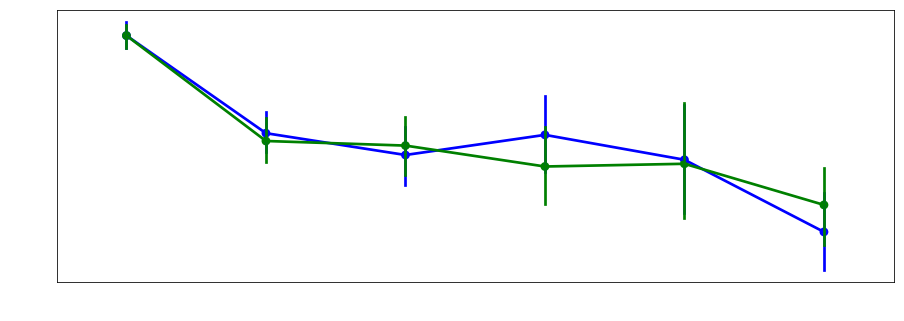

In [12]:
# ÁåúÊµãÔºöÁü≠ÊúüÂÜÖÈáçÂ§çÂá∫Áé∞ÁöÑprefixÔºåÊ†áÁ≠æÊòØÂê¶ÊúâËßÑÂæã
tempDf = df.sort_values(['prefix','instance_id'])
tempDf['temp'] = tempDf['prefix'].shift(1)
tempDf['pre_prefix'] = tempDf['instance_id'].shift(1)
tempDf['pre_prefix'] = tempDf['instance_id'] - tempDf['pre_prefix']
tempDf.loc[tempDf.prefix!=tempDf.temp, 'pre_prefix'] = -1
tempDf['temp'] = tempDf['prefix'].shift(-1)
tempDf['next_prefix'] = tempDf['instance_id'].shift(-1)
tempDf['next_prefix'] = tempDf['next_prefix'] - tempDf['instance_id']
tempDf.loc[tempDf.prefix!=tempDf.temp, 'next_prefix'] = -1

plt.figure(figsize=(15,5))
temp = pd.qcut(tempDf[tempDf.pre_prefix<50]['pre_prefix'], 15, duplicates='drop')
sns.pointplot(x=temp, y=tempDf[tempDf.pre_prefix<50]['label'], color='b')
temp = pd.qcut(tempDf[tempDf.next_prefix<50]['next_prefix'], 15, duplicates='drop')
sns.pointplot(x=temp, y=tempDf[tempDf.next_prefix<50]['label'], color='g')

/home/admin/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/admin/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


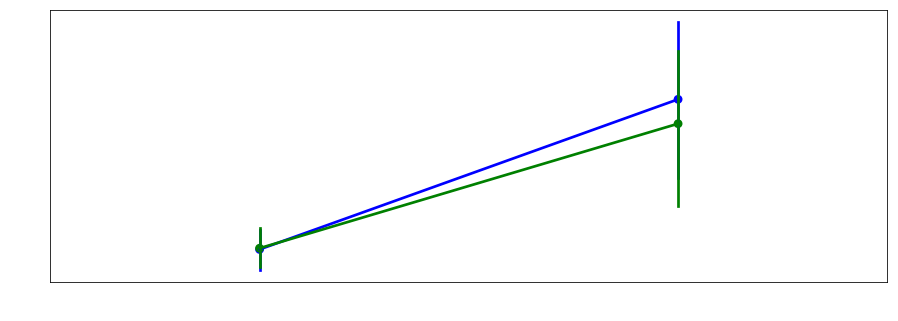

In [13]:
# È™åËØÅÈõÜÊòØÂê¶‰πüÊúâÁõ∏‰ººÁöÑÂàÜÂ∏ÉÔºüÔºü
tempDf = validDf.sort_values(['title','instance_id'])
tempDf['temp'] = tempDf['title'].shift(1)
tempDf['pre_title'] = tempDf['instance_id'].shift(1)
tempDf['pre_title'] = tempDf['instance_id'] - tempDf['pre_title']
tempDf.loc[tempDf.title!=tempDf.temp, 'pre_title'] = -1
tempDf['temp'] = tempDf['title'].shift(-1)
tempDf['next_title'] = tempDf['instance_id'].shift(-1)
tempDf['next_title'] = tempDf['next_title'] - tempDf['instance_id']
tempDf.loc[tempDf.title!=tempDf.temp, 'next_title'] = -1

plt.figure(figsize=(15,5))
temp = pd.qcut(tempDf[tempDf.pre_title<50]['pre_title'], 15, duplicates='drop')
sns.pointplot(x=temp, y=tempDf[tempDf.pre_title<50]['label'], color='b')
temp = pd.qcut(tempDf[tempDf.next_title<50]['next_title'], 15, duplicates='drop')
sns.pointplot(x=temp, y=tempDf[tempDf.next_title<50]['label'], color='g')

/home/admin/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/admin/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


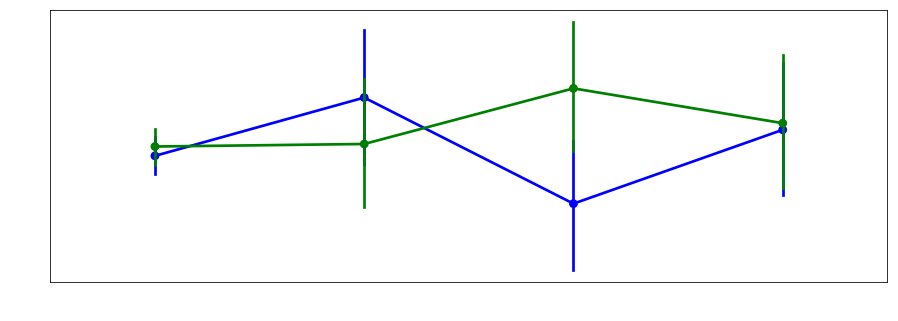

In [14]:
tempDf = validDf.sort_values(['prefix','instance_id'])
tempDf['temp'] = tempDf['prefix'].shift(1)
tempDf['pre_prefix'] = tempDf['instance_id'].shift(1)
tempDf['pre_prefix'] = tempDf['instance_id'] - tempDf['pre_prefix']
tempDf.loc[tempDf.prefix!=tempDf.temp, 'pre_prefix'] = -1
tempDf['temp'] = tempDf['prefix'].shift(-1)
tempDf['next_prefix'] = tempDf['instance_id'].shift(-1)
tempDf['next_prefix'] = tempDf['next_prefix'] - tempDf['instance_id']
tempDf.loc[tempDf.prefix!=tempDf.temp, 'next_prefix'] = -1

plt.figure(figsize=(15,5))
temp = pd.qcut(tempDf[tempDf.pre_prefix<50]['pre_prefix'], 15, duplicates='drop')
sns.pointplot(x=temp, y=tempDf[tempDf.pre_prefix<50]['label'], color='b')
temp = pd.qcut(tempDf[tempDf.next_prefix<50]['next_prefix'], 15, duplicates='drop')
sns.pointplot(x=temp, y=tempDf[tempDf.next_prefix<50]['label'], color='g')

In [15]:
print(tempDf[tempDf.pre_prefix<50].describe())

        instance_id         label  query_predict_num     flag    pre_prefix  \
count  27142.000000  27142.000000       27142.000000  27142.0  27142.000000   
mean   23223.438914      0.381254           9.918171      1.0      3.096271   
std    14739.257253      0.485704           2.743625      0.0     10.193282   
min        0.000000      0.000000           0.000000      1.0     -1.000000   
25%     9725.000000      0.000000          11.000000      1.0     -1.000000   
50%    22913.500000      0.000000          11.000000      1.0     -1.000000   
75%    35698.750000      1.000000          11.000000      1.0     -1.000000   
max    49999.000000      1.000000          11.000000      1.0     49.000000   

        next_prefix  
count  27142.000000  
mean    1488.314789  
std     4151.744708  
min       -1.000000  
25%       -1.000000  
50%       -1.000000  
75%       70.000000  
max    47083.000000  


/home/admin/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/admin/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/admin/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `ar

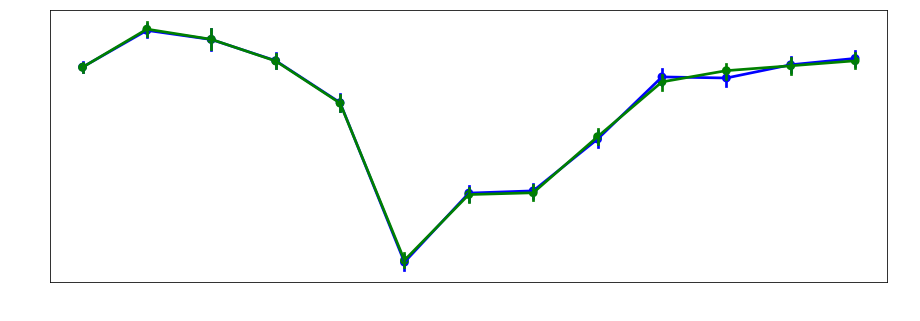

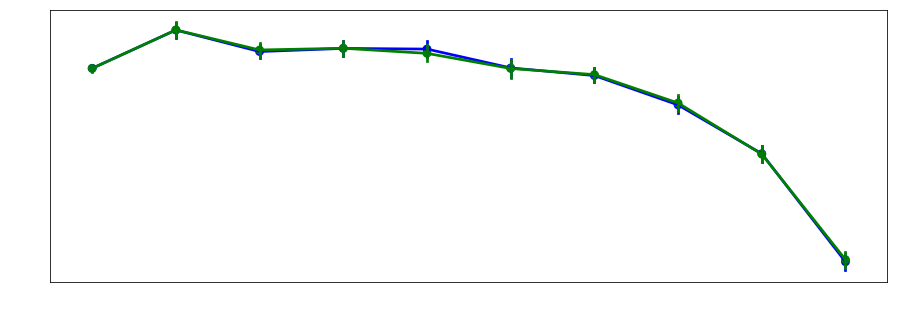

In [4]:
# ÊúâÂèØËÉΩÊòØÂêåtitle‰∏çÂêåtagÔºåËÄÉËôë‰∏ãtitleË∑ütagÁöÑÊãºÊé•‰ºö‰∏ç‰ºöÊõ¥ÂáÜÔºüÔºü
tempDf = df.sort_values(['title','tag','instance_id'])
tempDf['title_tag'] = tempDf['title'] + tempDf['tag']
tempDf['temp'] = tempDf['title_tag'].shift(1)
tempDf['pre_title_tag'] = tempDf['instance_id'].shift(1)
tempDf['pre_title_tag'] = tempDf['instance_id'] - tempDf['pre_title_tag']
tempDf.loc[tempDf.title_tag!=tempDf.temp, 'pre_title_tag'] = -1
tempDf['temp'] = tempDf['title_tag'].shift(-1)
tempDf['next_title_tag'] = tempDf['instance_id'].shift(-1)
tempDf['next_title_tag'] = tempDf['next_title_tag'] - tempDf['instance_id']
tempDf.loc[tempDf.title_tag!=tempDf.temp, 'next_title_tag'] = -1

plt.figure(figsize=(15,5))
temp = pd.qcut(tempDf['pre_title_tag'], 15, duplicates='drop')
sns.pointplot(x=temp, y=tempDf['label'], color='b')
temp = pd.qcut(tempDf['next_title_tag'], 15, duplicates='drop')
sns.pointplot(x=temp, y=tempDf['label'], color='g')

plt.figure(figsize=(15,5))
temp = pd.qcut(tempDf[tempDf.pre_title_tag<50]['pre_title_tag'], 15, duplicates='drop')
sns.pointplot(x=temp, y=tempDf[tempDf.pre_title_tag<50]['label'], color='b')
temp = pd.qcut(tempDf[tempDf.next_title_tag<50]['next_title_tag'], 15, duplicates='drop')
sns.pointplot(x=temp, y=tempDf[tempDf.next_title_tag<50]['label'], color='g')

## Á†îÁ©∂prefixÂú®title‰∏≠ÁöÑ‰ΩçÁΩÆ‰ø°ÊÅØ

In [4]:
# prefixÂú®title‰∏≠ÁöÑ‰ΩçÁΩÆ
df['prefix_title_pos'] = df[['prefix','title']].dropna().apply(lambda x: x.title.lower().find(x.prefix.lower()), axis=1)
df['prefix_isin_title'] = (df['prefix_title_pos']>-1).astype(int)
print(df.describe())

              label  query_predict_num       flag  prefix_title_pos  \
count  2.000000e+06       2.000000e+06  2000000.0      2.000000e+06   
mean   3.729595e-01       1.022344e+01        0.0      4.965080e-01   
std    4.835916e-01       2.408075e+00        0.0      1.974056e+00   
min    0.000000e+00       0.000000e+00        0.0     -1.000000e+00   
25%    0.000000e+00       1.100000e+01        0.0      0.000000e+00   
50%    0.000000e+00       1.100000e+01        0.0      0.000000e+00   
75%    1.000000e+00       1.100000e+01        0.0      0.000000e+00   
max    1.000000e+00       1.100000e+01        0.0      1.120000e+02   

       prefix_isin_title  
count       2.000000e+06  
mean        8.818405e-01  
std         3.227970e-01  
min         0.000000e+00  
25%         1.000000e+00  
50%         1.000000e+00  
75%         1.000000e+00  
max         1.000000e+00  


In [5]:
# prefixË∑ütitleÁöÑÈïøÂ∫¶
df['prefix_len'] = df['prefix'].dropna().map(lambda x: len(x))
df['title_len'] = df['title'].dropna().map(lambda x: len(x))
print(df.describe())

              label  query_predict_num       flag  prefix_title_pos  \
count  2.000000e+06       2.000000e+06  2000000.0      2.000000e+06   
mean   3.729595e-01       1.022344e+01        0.0      4.965080e-01   
std    4.835916e-01       2.408075e+00        0.0      1.974056e+00   
min    0.000000e+00       0.000000e+00        0.0     -1.000000e+00   
25%    0.000000e+00       1.100000e+01        0.0      0.000000e+00   
50%    0.000000e+00       1.100000e+01        0.0      0.000000e+00   
75%    1.000000e+00       1.100000e+01        0.0      0.000000e+00   
max    1.000000e+00       1.100000e+01        0.0      1.120000e+02   

       prefix_isin_title    prefix_len     title_len  
count       2.000000e+06  2.000000e+06  2.000000e+06  
mean        8.818405e-01  2.897248e+00  6.895180e+00  
std         3.227970e-01  1.371587e+00  5.960457e+00  
min         0.000000e+00  1.000000e+00  1.000000e+00  
25%         1.000000e+00  2.000000e+00  4.000000e+00  
50%         1.000000e+00  3.00

In [10]:
print(df.groupby('prefix_title_pos')['label'].agg([len,'mean']))

                      len      mean
prefix_title_pos                   
-1                 236319  0.155485
 0                1386321  0.434196
 1                  75192  0.267728
 2                 155573  0.329659
 3                  38248  0.277374
 4                  35121  0.317303
 5                  22658  0.215068
 6                  13607  0.239362
 7                  11478  0.180432
 8                   5953  0.191500
 9                   5670  0.178836
 10                  2836  0.167137
 11                  1986  0.135448
 12                  1696  0.144458
 13                   999  0.107107
 14                   834  0.131894
 15                   713  0.115007
 16                   684  0.096491
 17                   727  0.114168
 18                   457  0.113786
 19                   381  0.047244
 20                   236  0.088983
 21                   155  0.148387
 22                   298  0.073826
 23                   195  0.107692
 24                   125  0

1. ‰ªéÁªüËÆ°Êù•ÁúãÔºåÂ∞è‰∫é10ÁöÑ‰ΩçÁΩÆ‰ø°ÊÅØÁöÑÁÇπÂáªÁéáÂëàÊØîËæÉÊòéÊòæÁöÑÁ∫øÊÄßËßÑÂæãÔºåÂ∫îËØ•Â±û‰∫éÊØîËæÉÂº∫ÁöÑÁâπÂæÅ
1. ‰ΩçÁΩÆÁâπÂæÅÁöÑÊãñÂ∞æÂæàÈïø„ÄÇËÄåÁî±titleÁöÑÈïøÂ∫¶ÁªüËÆ°ÂèØÁü•Ôºå75%ÁöÑtitleÈïøÂ∫¶Â∞è‰∫éÁ≠â‰∫é8ÔºåÂõ†Ê≠§Â§ßÂ§öÊï∞Êï∞ÊçÆÁöÑ‰ΩçÁΩÆÁâπÂæÅÁêÜÂ∫î‰∏ç‰ºöÂ§™Â§ß
2. Âú®ÂÅöÁªÑÂêàÂàÜÊûêÊó∂ÔºåÂèØ‰ª•ËÄÉËôëÊåâÁÖß1w‰∏∫ÊúÄ‰ΩéÊ†∑Êú¨ÈáèÂØπ‰ΩçÁΩÆÁâπÂæÅËøõË°åÂàÜÁÆ±ÂêàÂπ∂


In [10]:
# ÂàÜÁÆ±ÂêàÂπ∂
df['prefix_title_pos_bin'] = df['prefix_title_pos'].copy()
df.loc[df.prefix_title_pos_bin.isin([8,9]), 'prefix_title_pos_bin'] = 8
df.loc[df.prefix_title_pos_bin>=10, 'prefix_title_pos_bin'] = 9
print(df.groupby('prefix_title_pos_bin')['label'].agg([len,'mean']))

                          len      mean
prefix_title_pos_bin                   
-1                     236319  0.155485
 0                    1386321  0.434196
 1                      75192  0.267728
 2                     155573  0.329659
 3                      38248  0.277374
 4                      35121  0.317303
 5                      22658  0.215068
 6                      13607  0.239362
 7                      11478  0.180432
 8                      11623  0.185322
 9                      13860  0.123737


In [12]:
# Á†îÁ©∂Ë∑üÂÖ∂‰ªñÁª¥Â∫¶ÁöÑ‰∫§ÂèâÁªüËÆ°ËßÑÂæã
tempDf = df.groupby(['tag','prefix_title_pos_bin'])['label'].agg([len,'mean'])
print(tempDf)

                             len      mean
tag prefix_title_pos_bin                  
ÂÅ•Â∫∑  -1                       147  0.210884
     0                     79188  0.346833
     1                      5570  0.257630
     2                     11515  0.237690
     3                      5286  0.186909
     4                      3611  0.162559
     5                      2214  0.122855
     6                      1830  0.106011
     7                      1503  0.090486
     8                      1855  0.076011
     9                      1844  0.037419
ÂïÜÂìÅ  -1                         5  0.000000
     0                      1909  0.117863
     1                       226  0.039823
     2                       403  0.181141
     3                       575  0.085217
     4                       668  0.064371
     5                       241  0.099585
     6                       191  0.115183
     7                       113  0.141593
     8                       173  0.080925
   

**Êúâ‰∫õÊòéÊòæÔºåÊúâ‰∫õÂπ∂Ê≤°ÊúâËßÑÂæãÔºå‰ºº‰πéË∑ütagÁõ∏ÂÖ≥„ÄÇÊÑüËßâÂØπ‰∫éÊ†ëÊ®°ÂûãÊù•ËØ¥ÔºåËøôÁªÑÁâπÂæÅÁöÑÊïàÊûúÈúÄË¶ÅÈ¶ñÂÖàËÉΩÂà§ÂÆötag**

In [23]:
# prefixÂú®title‰∏≠ÁöÑÁõ∏ÂØπ‰ΩçÁΩÆ
df['prefix_title_relative_pos'] = df['prefix_title_pos'] / df['title_len']
df.loc[df.prefix_title_relative_pos<0, 'prefix_title_relative_pos'] = np.nan
print(df.describe())

              label  query_predict_num       flag  prefix_title_pos  \
count  2.000000e+06       2.000000e+06  2000000.0      2.000000e+06   
mean   3.729595e-01       1.022344e+01        0.0      4.965080e-01   
std    4.835916e-01       2.408075e+00        0.0      1.974056e+00   
min    0.000000e+00       0.000000e+00        0.0     -1.000000e+00   
25%    0.000000e+00       1.100000e+01        0.0      0.000000e+00   
50%    0.000000e+00       1.100000e+01        0.0      0.000000e+00   
75%    1.000000e+00       1.100000e+01        0.0      0.000000e+00   
max    1.000000e+00       1.100000e+01        0.0      1.120000e+02   

       prefix_isin_title    prefix_len     title_len  prefix_title_pos_bin  \
count       2.000000e+06  2.000000e+06  2.000000e+06          2.000000e+06   
mean        8.818405e-01  2.897248e+00  6.895180e+00          4.491245e-01   
std         3.227970e-01  1.371587e+00  5.960457e+00          1.568726e+00   
min         0.000000e+00  1.000000e+00  1.000000

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


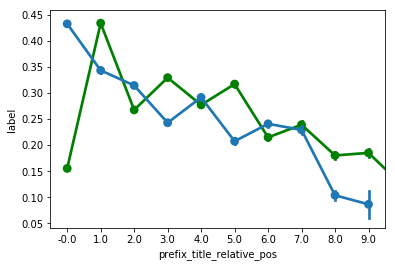

In [24]:
tempDf = df[['prefix_title_relative_pos','prefix_title_pos_bin','prefix_title_pos','label']]
tempDf['prefix_title_relative_pos'] = tempDf['prefix_title_relative_pos'] // 0.1
sns.pointplot(x="prefix_title_pos_bin", y="label", data=tempDf, color='g')
sns.pointplot(x="prefix_title_relative_pos", y="label", data=tempDf)

## ÊñáÊú¨Â≠óÁ¨¶È¢ÑÂ§ÑÁêÜ

In [12]:
str1 = df['prefix'].unique()[:10]
str2 = df['prefix'].sort_values().tail(10).values
print(str1, str2)
print([list(jieba.cut(s.lower())) for s in str1])
print([list(jieba.cut(s.lower())) for s in str2])
print(list(jieba.cut('Â§ö‰πÖÁöÑ%2CË±ÜÊµÜ')))

['ÁæÅ' '\x08ÂÖ≠Âêà' 'Á∫¢Â≤©Èáë' 'È´òÂæ∑Âú∞Âõæ' '12306' '!ÊòØ‰ªÄ‰πàÊÑèÊÄù' '0p' 'ÁâõÂ•∂' '‰∏≠ÂõΩÂøóÊÑø' 'ÁΩëÊòì‰∫ë'] ['üòÇ' 'üòÉ' 'üòÉ' 'üòÉ' 'üòè' 'üòí' 'üòí' 'üòí ' 'üòî' 'üôÉ ']
[['ÁæÅ'], ['\x08', 'ÂÖ≠Âêà'], ['Á∫¢Â≤©', 'Èáë'], ['È´òÂæ∑', 'Âú∞Âõæ'], ['12306'], ['!', 'ÊòØ', '‰ªÄ‰πà', 'ÊÑèÊÄù'], ['0p'], ['ÁâõÂ•∂'], ['‰∏≠ÂõΩ', 'ÂøóÊÑø'], ['ÁΩëÊòì', '‰∫ë']]
[['üòÇ'], ['üòÉ'], ['üòÉ'], ['üòÉ'], ['üòè'], ['üòí'], ['üòí'], ['üòí', ' '], ['üòî'], ['üôÉ', ' ']]
['Â§ö‰πÖ', 'ÁöÑ', '%', '2C', 'Ë±ÜÊµÜ']


1. ÂØπ‰∫éÈÄóÂè∑ÁºñÁ†ÅÔºà%2CÔºâÔºåjiebaËØÜÂà´‰∏çË∂≥ÔºåÂèØ‰ª•Âú®ÂàÜËØçÂâçËøõË°åÁªü‰∏ÄÊõøÊç¢
2. ÂØπ‰∫éË°®ÊÉÖ„ÄÅ16ËøõÂà∂Á¨¶Á≠âÁºñÁ†ÅÁ±ªÊñáÊú¨ÔºåjiebaÂèØ‰ª•ÂæàÂ•ΩÁöÑÂàÜËØçÔºå‰∏çÈúÄË¶ÅËøõË°åÈ¢ùÂ§ñÂ§ÑÁêÜ

In [16]:
# Ê£ÄÊü•ÊòØÂê¶ËøòÊúâÁ±ª‰ºº%2CÁöÑÂ≠óÁ¨¶ÁºñÁ†Å
titleDf = df[['title']].drop_duplicates()
titleDf['title'] = titleDf['title'].map(lambda x: x.replace('%2C', ','))
titleDf['code'] = titleDf['title'].map(lambda x: re.search('%[\da-zA-Z]+', x))
titleDf['code'] = titleDf['code'].dropna().map(lambda x: x.group())
print(titleDf[titleDf.code.notnull()][['title','code']])

                                                     title        code
10762                                           6%DOKIDOKI   %DOKIDOKI
249040   #include<stdio.h> int main() {int a=5,b=6,c=7,...          %d
630606    ÊüêÂÖ¨Âè∏ÂêëË•øÊ¨ßÊé®ÈîÄÁÆ±Ë£ÖË¥ßÔºåÂéüÊä•‰ª∑ÊØèÁÆ±50ÁæéÂÖÉFOB‰∏äÊµ∑ÔºåÁé∞ÂÆ¢Êà∑Ë¶ÅÊ±ÇÊîπÊä•CFRC3%Hamburg„ÄÇ    %Hamburg
1022752          int y=2456; printf("y=%3o\n",y); ËæìÂá∫ÁªìÊûúÊòØ‰ªÄ‰πàÔºü         %3o
1370505                Â§ßÂß®Â¶àÂç†ÂçúÔºåÂæàÂáÜÁöÑÔºÅÊúàÁªèÊó•Êúü‰ª£Ë°®‰Ω†‰∏Ä‰∏™ÊúàÂ∞ÜË¶ÅÂèëÁîüÁöÑ‰∫ãÔºå80%MMÈÉΩÂáÜÂì¶         %MM
1563127                                 100%polyesterÊòØ‰ªÄ‰πàÈù¢Êñô  %polyester
1602385                        „ÄêËÄΩÁæéÈ´ò%h„ÄëËÄΩÁæéÂä®Êº´„ÄÇ„ÄÇÈ´òHÁü≠ÁâáÁöÑ/Ë¶ÅÁî∑‚ÄîÁà±ÈóÆÁü•ËØÜ‰∫∫          %h
1938767            Âõ¢‰∏≠Â§ÆÊâÄÊî∂Áº¥Âõ¢Ë¥π‰∏≠ÁöÑÔºà)ËøîËøòÊîØÊåÅÂü∫Â±Ç„ÄÇA„ÄÅ60%B„ÄÅ65%C„ÄÅ70%D„ÄÅ80%          %B
